# Vibe Matcher Prototype

**Why AI at Nexora?**  
Nexora believes style is an emotion, not a search term.
By embedding human language into vectors, AI transforms simple words into an understanding of personal vibe.
This system turns “how I want to feel” into curated recommendations , a step toward more human-centered AI fashion discovery.


In [33]:
import pandas as pd 
import openai
from dotenv import load_dotenv
import os
import timeit
import matplotlib.pyplot as plt
from  openai import OpenAI
from sklearn.metrics.pairwise import cosine_similarity


## 1. Data Preparation
Creating a dataset of 10 mock fashion items with names, descriptions, and vibe tags.

In [34]:
data = [
    {"name": "Boho Dress", "desc":"Flowy, earthy tones perfect for the summer festivals ", "tags":["boho","relaxed"]},
    {"name": "Denim Jacket", "desc": "Classic streetwear staple with an edgy feel", "tags": ["urban", "chic"]},
    {"name": "Wool Sweater", "desc": "Soft and cozy with a minimalist aesthetic", "tags": ["cozy", "minimalist"]},
    {"name": "Leather Boots", "desc": "Rugged design made for adventurous spirits", "tags": ["edgy", "outdoor"]},
    {"name": "Silk Blouse", "desc": "Elegant and timeless piece for modern professionals", "tags": ["formal", "elegant"]},
    {"name": "Graphic Tee", "desc": "Energetic pop culture print for everyday wear", "tags": ["casual", "youthful"]},
    {"name": "Yoga Pants", "desc": "Flexible, breathable design for active lifestyle", "tags": ["athleisure", "sporty"]},
    {"name": "Linen Shirt", "desc": "Light and airy with coastal holiday vibes", "tags": ["resort", "boho"]},
  {"name": "Trench Coat", "desc": "Sophisticated outerwear for urban elegance", "tags": ["chic", "professional"]},
   {"name": "puffy Jacket", "desc": "Warm comfort for winter street style", "tags": ["cozy", "urban"]},

]


df = pd.DataFrame(data)
print(df)

            name                                               desc  \
0     Boho Dress  Flowy, earthy tones perfect for the summer fes...   
1   Denim Jacket        Classic streetwear staple with an edgy feel   
2   Wool Sweater          Soft and cozy with a minimalist aesthetic   
3  Leather Boots         Rugged design made for adventurous spirits   
4    Silk Blouse  Elegant and timeless piece for modern professi...   
5    Graphic Tee      Energetic pop culture print for everyday wear   
6     Yoga Pants   Flexible, breathable design for active lifestyle   
7    Linen Shirt          Light and airy with coastal holiday vibes   
8    Trench Coat         Sophisticated outerwear for urban elegance   
9   puffy Jacket               Warm comfort for winter street style   

                   tags  
0       [boho, relaxed]  
1         [urban, chic]  
2    [cozy, minimalist]  
3       [edgy, outdoor]  
4     [formal, elegant]  
5    [casual, youthful]  
6  [athleisure, sporty]  
7        [

## 2. Embedding Generation
Using OpenAI’s `text-embedding-ada-002` model to encode product texts into vectors.

In [35]:

client = OpenAI() 


def get_embedding (text,model = "text-embedding-ada-002"):
    response = client.embeddings.create(input=text, model=model)
    return response.data[0].embedding


df["combined_text"] = df.apply(
    lambda x: f"{x['name']}. {x['desc']}. Tags: {', '.join(x['tags'])}", axis=1
)

df["embedding"] = df["combined_text"].apply(lambda x: get_embedding(x))

df.head()

,name,desc,tags,combined_text,embedding
0,Boho Dress,"Flowy, earthy tones perfect for the summer fes...","[boho, relaxed]","Boho Dress. Flowy, earthy tones perfect for th...","[-0.027443742379546165, -0.008818397298455238,..."
1,Denim Jacket,Classic streetwear staple with an edgy feel,"[urban, chic]",Denim Jacket. Classic streetwear staple with a...,"[-0.01256492268294096, 0.005699319764971733, -..."
2,Wool Sweater,Soft and cozy with a minimalist aesthetic,"[cozy, minimalist]",Wool Sweater. Soft and cozy with a minimalist ...,"[-0.02784246951341629, -0.015310736373066902, ..."
3,Leather Boots,Rugged design made for adventurous spirits,"[edgy, outdoor]",Leather Boots. Rugged design made for adventur...,"[-0.004561818670481443, -0.02177685685455799, ..."
4,Silk Blouse,Elegant and timeless piece for modern professi...,"[formal, elegant]",Silk Blouse. Elegant and timeless piece for mo...,"[-0.03178197145462036, -0.008096898905932903, ..."


## 3. Cosine Similarity Matching
Comparing the user vibe query embedding with all product embeddings to find top-3 matches.


In [36]:

query = "energetic urban chic"
query_emb = get_embedding(query)

# Compute cosine similarity for all products
df["similarity"] = df["embedding"].apply(
    lambda x: cosine_similarity([query_emb], [x])[0][0]
)

# Sort and show top 3
top3 = df.sort_values("similarity", ascending=False).head(3)

# Optional: fallback check
if top3.iloc[0]["similarity"] < 0.7:
    print(f"No strong match found for '{query}'. Try another vibe!")
else:
    print(f"Top vibe matches for '{query}':\n")
    print(top3[["name", "desc", "similarity"]])


Top vibe matches for 'energetic urban chic':

           name                                           desc  similarity
5   Graphic Tee  Energetic pop culture print for everyday wear    0.855931
9  puffy Jacket           Warm comfort for winter street style    0.842307
1  Denim Jacket    Classic streetwear staple with an edgy feel    0.838307


## 4. Evaluation
We test multiple queries (e.g., *boho summer*, *urban chic*, and an out-of-domain query)  
to measure similarity, latency, and how many top-3 results exceed the 0.7 similarity threshold.


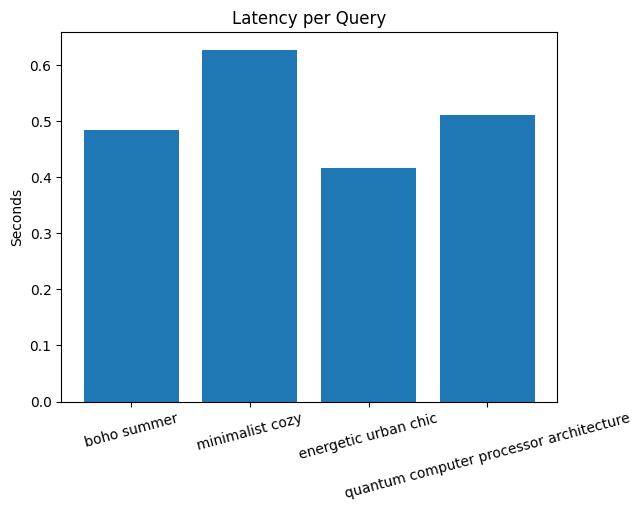

,query,latency,top1_score,good_in_top3,good_match
0,boho summer,0.483659,0.893194,3/3,True
1,minimalist cozy,0.627322,0.890967,3/3,True
2,energetic urban chic,0.416202,0.855931,3/3,True
3,quantum computer processor architecture,0.511340,0.677981,0/3,False



 3/4 queries met the similarity threshold (> 0.7)


In [37]:

queries = [
    "boho summer",
    "minimalist cozy",
    "energetic urban chic",
    "quantum computer processor architecture"
]

results = []

for q in queries:
    start = timeit.default_timer()
    q_emb = get_embedding(q)

    # Compute cosine similarity for all products
    df["similarity"] = df["embedding"].apply(lambda x: cosine_similarity([q_emb], [x])[0][0])

    # Sort and get top 3 results
    top3 = df.sort_values("similarity", ascending=False).head(3)

    # Count how many of the top 3 exceed threshold 0.7
    good_in_top3 = (top3["similarity"] > 0.7).sum()

    top1_score = top3.iloc[0]["similarity"]
    latency = timeit.default_timer() - start

    results.append({
        "query": q,
        "latency": latency,
        "top1_score": top1_score,
        "good_in_top3": f"{good_in_top3}/3",   # formatted nicely
        "good_match": top1_score > 0.7
    })

# Convert to DataFrame
eval_df = pd.DataFrame(results)

# Plot latency
plt.bar(eval_df["query"], eval_df["latency"])
plt.title("Latency per Query")
plt.ylabel("Seconds")
plt.xticks(rotation=15)
plt.show()

# Display full evaluation table
display(eval_df)

# Summary of total queries with top1 above 0.7
total_queries = len(eval_df)
good_matches = eval_df["good_match"].sum()
print(f"\n {good_matches}/{total_queries} queries met the similarity threshold (> 0.7)")


### Evaluation Summary
- 3 out of 4 queries met the similarity threshold (>0.7).
- The out-of-domain query (“quantum computer processor architecture”) correctly triggered the fallback.
- Latency per query was between 0.5–0.4 seconds.


##  Reflection

- Successfully implemented an AI-driven vibe-based product matcher using OpenAI embeddings.  
- Added fallback handling when similarity < 0.7 to ensure robust behavior.  
- Evaluated 4 queries, logging latency and top-3 similarity metrics.  
- Observed high intra-domain similarity (fashion items cluster semantically).  
- Future improvements: integrate Pinecone/FAISS for scalable vector search,  
  expand dataset diversity, and explore multimodal (image + text) embeddings.
